In [1]:
import numpy as np
import pandas as pd
import requests
import urllib.request
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import metrics
import seaborn as sns
%matplotlib inline

import re
import os
import glob
from datetime import datetime as dt
import warnings
from time import sleep
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Read the CSV and Perform Basic Data Cleaning

In [3]:
# https://github.com/Hecgithub/House_Price_Prediction/blob/03_Data_Gathering_and_Cleaning/03_Code_and_Data/03_Data_Cleaning/data/For_ML/ML_data_Houston_TX_Houses_merged_2023_1_1_12_5.csv

columns = [
    "Lat","Lng","Price","Bedrooms","Bathrooms","constructedArea","zipCode",
    "hasGarage","hasPool","hasCooling","hasView","yearBuilt","stories","parkingSpaces",
    "annualHOI","schoolElemRating","schoolElemDist","schoolMidRating","schoolMidDist",
    "schoolHighRating","schoolHighDist","priceIncreased","priceDiff","days","lotAreaSQFT"
]

target = ["Price"]

In [4]:
# reading in the data set from the github 
url = 'https://raw.githubusercontent.com/Hecgithub/House_Price_Prediction/03_Data_Gathering_and_Cleaning/03_Code_and_Data/03_Data_Cleaning/data/For_ML/ML_data_Houston_TX_Houses_merged_2023_1_1_12_5.csv'

urllib.request.urlretrieve(url, 'ML_data_Houston_TX_Houses_merged_2023_1_1_12_5.csv')

('ML_data_Houston_TX_Houses_merged_2023_1_1_12_5.csv',
 <http.client.HTTPMessage at 0x1e93324ab08>)

In [5]:
# There are 25 columns and 4499 rows 
df = pd.read_csv('ML_data_Houston_TX_Houses_merged_2023_1_1_12_5.csv')
print(df.shape)

(4499, 25)


In [6]:
# Peek at the dateset
df.head()

,Lat,Lng,Price,Bedrooms,Bathrooms,constructedArea,zipCode,hasGarage,hasPool,hasCooling,hasView,yearBuilt,stories,parkingSpaces,annualHOI,schoolElemRating,schoolElemDist,schoolMidRating,schoolMidDist,schoolHighRating,schoolHighDist,priceIncreased,priceDiff,days,lotAreaSQFT
0,29.603600,-95.485405,276000,3,2,3612,77489,1,0,1,0,1971,2,2,1159,6,0.5,3,1.3,2,1.1,1,31000,1213,8764.272
1,29.600388,-95.488210,220000,3,2,1270,77489,1,0,1,0,1972,1,1,924,6,0.3,3,1.3,2,1.0,1,65100,503,7884.360
2,29.595436,-95.485880,230000,4,2,1765,77489,1,0,1,0,1974,1,2,966,6,0.3,3,1.0,2,0.6,1,115275,5140,7148.196
3,29.597320,-95.492690,225000,3,2,1444,77489,1,0,1,0,1978,1,2,945,6,0.1,3,1.4,2,1.0,1,56000,824,7731.900
4,29.592060,-95.489050,246500,3,2,1738,77489,1,0,1,0,1978,1,2,1035,6,0.3,3,1.0,2,0.6,1,41500,6810,8062.956


In [7]:
# Checking the features of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4499 entries, 0 to 4498
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Lat               4499 non-null   float64
 1   Lng               4499 non-null   float64
 2   Price             4499 non-null   int64  
 3   Bedrooms          4499 non-null   int64  
 4   Bathrooms         4499 non-null   int64  
 5   constructedArea   4499 non-null   int64  
 6   zipCode           4499 non-null   int64  
 7   hasGarage         4499 non-null   int64  
 8   hasPool           4499 non-null   int64  
 9   hasCooling        4499 non-null   int64  
 10  hasView           4499 non-null   int64  
 11  yearBuilt         4499 non-null   int64  
 12  stories           4499 non-null   int64  
 13  parkingSpaces     4499 non-null   int64  
 14  annualHOI         4499 non-null   int64  
 15  schoolElemRating  4499 non-null   int64  
 16  schoolElemDist    4499 non-null   float64


In [8]:
# Remove outlier price:
df = df[df['Price'] >= 200000] 

# Average the school rates and distances
df['avgSchoolRating'] = df[['schoolElemRating', 'schoolMidRating', 'schoolHighRating']].mean(axis=1)
df['avgSchoolDist'] = df[['schoolElemDist', 'schoolMidDist', 'schoolHighDist']].mean(axis=1)


In [9]:
# Remove unwanted features
df = df.drop(['annualHOI', 'days', 'priceDiff', 'priceIncreased', 'Lat', 'Lng', 'schoolElemRating', 'schoolMidRating', 'schoolHighRating', 'schoolElemDist', 'schoolMidDist', 'schoolHighDist'], axis=1)

In [10]:
# Peek at the dateset
df.head()

,Price,Bedrooms,Bathrooms,constructedArea,zipCode,hasGarage,hasPool,hasCooling,hasView,yearBuilt,stories,parkingSpaces,lotAreaSQFT,avgSchoolRating,avgSchoolDist
0,276000,3,2,3612,77489,1,0,1,0,1971,2,2,8764.272,3.666667,0.966667
1,220000,3,2,1270,77489,1,0,1,0,1972,1,1,7884.360,3.666667,0.866667
2,230000,4,2,1765,77489,1,0,1,0,1974,1,2,7148.196,3.666667,0.633333
3,225000,3,2,1444,77489,1,0,1,0,1978,1,2,7731.900,3.666667,0.833333
4,246500,3,2,1738,77489,1,0,1,0,1978,1,2,8062.956,3.666667,0.633333


In [11]:
# Find columns with missing values and their percent missing
df.isnull().sum()                                                     
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissvalCount'])
miss_val


,MissvalCount
Price,0
Bedrooms,0
Bathrooms,0
constructedArea,0
zipCode,0
hasGarage,0
hasPool,0
hasCooling,0
hasView,0
yearBuilt,0


In [12]:
# drop rows with any missing values
df.dropna(inplace=True)

In [13]:
# Check the dimension of the dataset
df.shape

(4498, 15)

Data set is clean and there is still 25 features and 4499 observations 

# Explore Data

In [14]:
# Get statistics
df.describe()

,Price,Bedrooms,Bathrooms,constructedArea,zipCode,hasGarage,hasPool,hasCooling,hasView,yearBuilt,stories,parkingSpaces,lotAreaSQFT,avgSchoolRating,avgSchoolDist
count,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000
mean,401394.400178,3.400845,2.836149,2159.437972,77070.781903,0.834593,0.062250,0.957759,0.010671,1993.488662,1.689418,1.744775,7290.854534,4.261820,1.718067
std,156990.084336,0.701705,0.878959,709.985274,81.286338,0.371589,0.241636,0.201161,0.102761,28.984694,0.728882,0.800961,8653.115673,1.374233,1.190225
min,200000.000000,1.000000,1.000000,480.000000,77003.000000,0.000000,0.000000,0.000000,0.000000,1888.000000,1.000000,0.000000,1240.000000,2.000000,0.166667
25%,280000.000000,3.000000,2.000000,1681.000000,77022.000000,1.000000,0.000000,1.000000,0.000000,1970.000000,1.000000,2.000000,4229.676000,3.000000,0.933333
50%,364000.000000,3.000000,3.000000,2020.000000,77057.000000,1.000000,0.000000,1.000000,0.000000,2003.000000,2.000000,2.000000,6993.558000,4.000000,1.333333
75%,469990.000000,4.000000,3.000000,2528.750000,77084.000000,1.000000,0.000000,1.000000,0.000000,2022.000000,2.000000,2.000000,8158.788000,5.333333,1.966667
max,900000.000000,8.000000,7.000000,6793.000000,77598.000000,1.000000,1.000000,1.000000,1.000000,2023.000000,5.000000,9.000000,174240.000000,9.000000,5.100000


<AxesSubplot:>

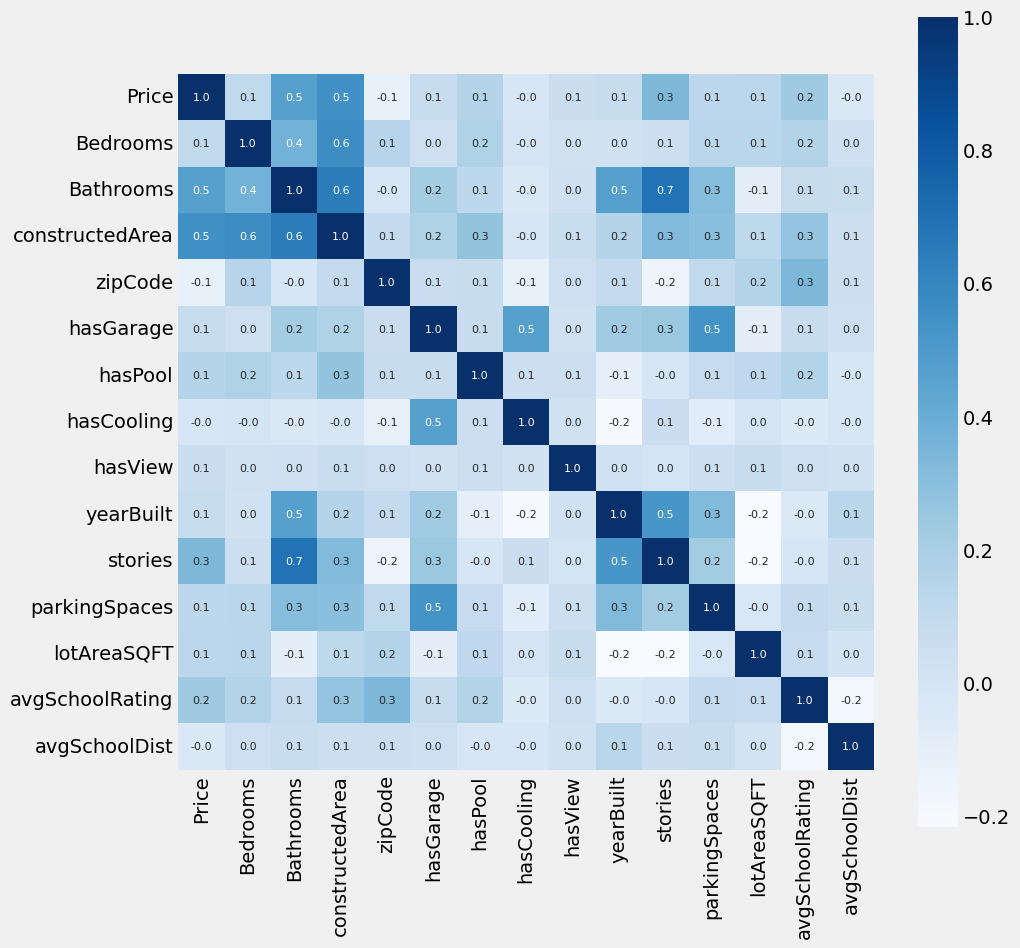

In [15]:
# Heat map
# A heat map shows the correlation between the input data columns
# There are 2 types of correlation:
# Positive: As the magnitude of a feature increases, the magnitude of a correlated feature increases
# Negative: As the magnitude of a feature increases, the magnitude of a correlated feature decreases
correlation = df.corr()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

<AxesSubplot:xlabel='Price', ylabel='Density'>

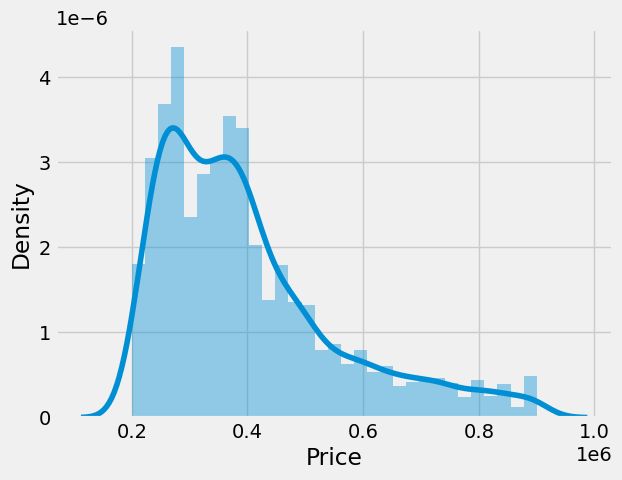

In [16]:
# Check distribution of target variable which is Price
sns.distplot(df.Price)

The Price distribution is slightly skewed to the right. 

In [17]:
# Review the skewness of each feature
df.skew().sort_values(ascending=False)

lotAreaSQFT        10.877242
hasView             9.527836
hasPool             3.624835
zipCode             3.038267
avgSchoolDist       1.505410
Price               1.215035
constructedArea     1.210304
stories             0.898427
Bedrooms            0.839981
avgSchoolRating     0.648713
Bathrooms           0.269482
parkingSpaces      -0.129126
yearBuilt          -0.619385
hasGarage          -1.801680
hasCooling         -4.553198
dtype: float64

Values that are closer to zero are less skewed. 

# Train- Test Split dataset


In [18]:
# Get the features and the target column 
# X = Features, y = target
X = df.drop('Price', axis=1)
y = df[["Price"]]

In [19]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X.shape, X_train.shape, X_test.shape)

(4498, 14) (3598, 14) (900, 14)


Spliting the data set, will use random sampling with 80/20 train-test split. 

# Modeling

## Linear Regression 

In [20]:
lr = LinearRegression()
# fit optimal linear regression line on training data, this performs gradient descent under the hood
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
# given our model and our fit, predict y_values using X_test set
yr_hat = lr.predict(X_test)

In [22]:
# evaluate the algorithm with a test set 
lr_score = lr.score(X_test, y_test)  # train test 
print("Accuracy: ", lr_score)

Accuracy:  0.4379082337285074


In [23]:
# cross validation to find 'validate' score across multiple samples, automatically does Kfold stratifying
lr_cv = cross_val_score(lr, X, y, cv = 5, scoring= 'r2')
print("Cross-validation results: ", lr_cv)
print("R2: ", lr_cv.mean())

Cross-validation results:  [0.08163553 0.30959832 0.27968541 0.52160289 0.45697985]
R2:  0.32990039896087026


## Random Forest

In [24]:
#rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5, min_samples_leaf= 5, max_features = 'sqrt')  # using GridSearch
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # gets the parameters for the rfr model
rfr_cv = cross_val_score(rfr,X, y, cv = 5, scoring = 'r2')
print("R2: ", rfr_cv.mean())

R2:  0.6197259744926326


In [25]:
# Random forest determined feature importances
rfr.feature_importances_

array([0.01869843, 0.04616548, 0.39149173, 0.16497261, 0.004174  ,
       0.00474676, 0.00069964, 0.0008466 , 0.10655215, 0.01008275,
       0.01243481, 0.10994389, 0.07624654, 0.05294461])

## XGBRegressor

In [26]:
# Load the model (XGBoost Regressor)
model = XGBRegressor()

# Train the model with the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [27]:
y_test_predicted = model.predict(X_test)

# Calculate the R squared error
error_r2 = metrics.r2_score(y_test, y_test_predicted)

# Calculate the mean absolute error
error_ma = metrics.mean_absolute_error(y_test, y_test_predicted)

print(f'R squared error: {error_r2} (should be close to 1)')

R squared error: 0.7565280887528846 (should be close to 1)


## Plotting Feature Importance 

In [28]:
# Display the actual price vs the predicted price
y_test_df = y_test.reset_index(drop=True)
y_test_df = y_test_df.rename(columns = {'Price':'Actual_Price'})

y_pred_df = pd.DataFrame(y_test_predicted, columns = ['Predicted_Price'])
y_pred_df = y_pred_df['Predicted_Price'].apply(np.ceil).astype('int')

# Display the actual and the predicted prices side by side
df_prices = pd.concat([y_test_df, y_pred_df], axis=1)
df_prices

,Actual_Price,Predicted_Price
0,325000,343917
1,354999,313158
2,255900,272475
3,309990,311733
4,279000,462661
...,...,...
895,449900,431599
896,374900,321803
897,395000,439712
898,219900,246170


In [29]:
importance = rfr.feature_importances_

# map feature importance values to the features
feature_importances = zip(importance, X.columns)
#list(feature_importances)

sorted_feature_importances = sorted(feature_importances, reverse = True)
#print(sorted_feature_importances)

top_15_predictors = sorted_feature_importances[0:15]
values = [value for value, predictors in top_15_predictors]
predictors = [predictors for value, predictors in top_15_predictors]
print(predictors)

['constructedArea', 'zipCode', 'lotAreaSQFT', 'yearBuilt', 'avgSchoolRating', 'avgSchoolDist', 'Bathrooms', 'Bedrooms', 'parkingSpaces', 'stories', 'hasPool', 'hasGarage', 'hasView', 'hasCooling']


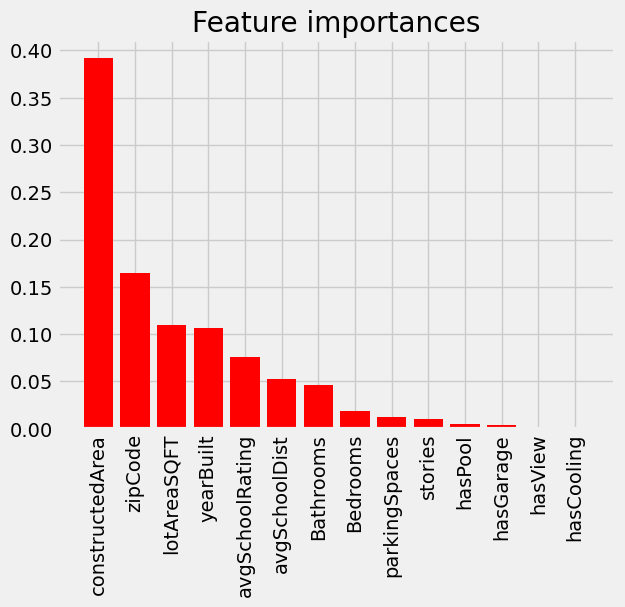

In [30]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

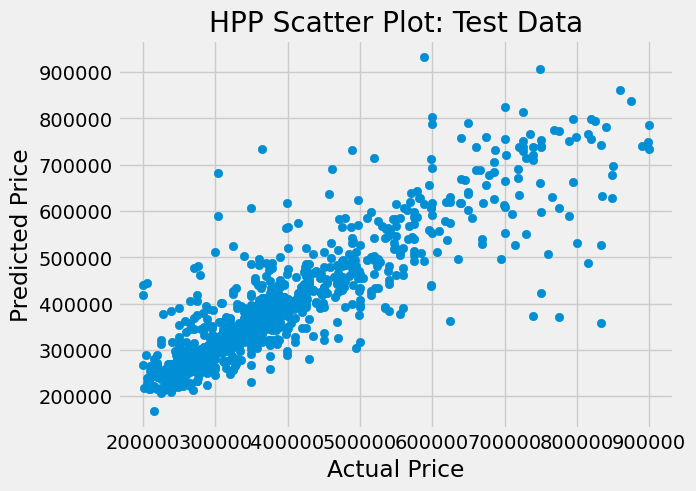

In [31]:
# Scatter Plot using test data
plt.scatter(y_test_df, y_pred_df)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('HPP Scatter Plot: Test Data')
plt.show()